<a href="https://colab.research.google.com/github/ajagota7/Reward-Shaping/blob/main/gridworld_ope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np
import os
from google.colab import drive
import pickle
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Creating Environment

In [21]:

class GridWorld:
    def __init__(self, height, width, start, end, bad_regions, good_regions, good_region_reward, bad_region_reward, final_reward, sparsity):
        self.height = height
        self.width = width
        self.start = start
        self.end = end
        self.bad_regions = bad_regions
        self.good_regions = good_regions
        self.good_region_reward = good_region_reward
        self.bad_region_reward = bad_region_reward
        self.final_reward = final_reward
        self.sparsity = sparsity

        self.state_rewards = self.generate_state_rewards()
        self.reset()

    def reset(self):
        self.agent_position = self.start

    def generate_state_rewards(self):
        state_rewards = {}
        for x in range(self.width):
            for y in range(self.height):
                # if (x, y) in self.good_regions:
                #     state_rewards[(x, y)] = self.good_region_reward
                # elif (x, y) in self.bad_regions:
                #     state_rewards[(x, y)] = self.bad_region_reward
                if (x,y) == self.start:
                  state_rewards[(x,y)] = 0
                elif (x,y) == self.end:
                  state_rewards[(x,y)] = self.final_reward
                else:
                    state_rewards[(x, y)] = 0.5 if np.random.random() < self.sparsity else 0.0
        return state_rewards

    def step(self, action, is_eval_policy):
        x, y = self.agent_position

        # Get the reward based on the current state and policy context
        reward = self.state_rewards.get((x, y), 0)

        if action == "up" and y < self.height - 1:
            y += 1
        elif action == "down" and y > 0:
            y -= 1
        elif action == "left" and x > 0:
            x -= 1
        elif action == "right" and x < self.width - 1:
            x += 1

        # Update agent position
        self.agent_position = (x, y)

        # Get the reward based on the current state and policy context
        reward = self.state_rewards.get(self.agent_position, 0)

        # Update state_rewards for self.agent_position if needed
        if is_eval_policy:
            if self.agent_position in self.good_regions:
                self.state_rewards[self.agent_position] = self.good_region_reward
            elif self.agent_position in self.bad_regions:
                self.state_rewards[self.agent_position] = self.bad_region_reward

        if self.agent_position in self.end:
            done = True
        else:
            done = False

        # Get the reward for the updated position and policy context
        updated_reward = self.state_rewards.get(self.agent_position, 0)

        # Check if the new position is the end state
        done = (self.agent_position == self.end)

        return self.agent_position, updated_reward, done



In [22]:
import numpy as np

class Agent:
    def __init__(self, epsilon=0.0):
        self.epsilon = epsilon

    def select_action(self, policy_func):
        if np.random.uniform() < self.epsilon:
            # Choose a random action
            action = np.random.choice(["up", "down", "left", "right"])
        else:
            # Use the provided policy function to get the best action
            action = policy_func()
        return action

# Define different policy functions outside the class

def random_policy():
    # Choose a random action
    return np.random.choice(["up", "down", "left", "right"])

# def behavior_policy(behav_policy):
#     action_probs = behav_policy
#     return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

# def evaluation_policy(eval_policy):
#     action_probs = eval_policy
#     return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

def run_policy(policy):
    action_probs = policy
    return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))


def manhattan_distance(pos1, pos2):
    # Compute the Manhattan distance between two positions
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}

# Generating Policy data

In [23]:
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

In [24]:
def create_policy_set(env, policy_func, policy, num_episodes):
  # Create a list to store policies as trajectories
  policies = []

  # Run multiple episodes
  for episode in range(num_episodes):
      # Create a new Agent for each episode to generate a different policy

      agent = Agent(epsilon=0.0)

      # print(episode)
      # Run an episode
      env.reset()
      done = False
      trajectory = []  # Store the trajectory for the current episode
      cumulative_reward = 0.0  # Initialize cumulative reward
      while not done:
          state = env.agent_position  # Get the current state
          # print("State: ",state)
          action = agent.select_action(lambda: policy_func(policy))
          # print("Action: ",action)
          next_state, reward, done = env.step(action, policy == eval_policy)
          # print("Next State: ", next_state)

          # Compute cumulative reward
          cumulative_reward += reward

          # Compute feature function values (manhattan distances)
          good_region_distances = [manhattan_distance(state, gr) for gr in env.good_regions]
          bad_region_distances = [manhattan_distance(state, br) for br in env.bad_regions]

          # Store the (state, action, reward, next_state) tuple in the trajectory
          trajectory.append((state, action, reward, next_state, cumulative_reward, good_region_distances, bad_region_distances))

      # Append the trajectory to the policies list
      policies.append(trajectory)

  return policies


In [25]:
def calc_V_pi_e(evaluation_policies):
    all_timesteps = []
    gamma = 0.9
    for j in range(len(evaluation_policies)):
        Timestep_values = []
        for i in range(len(evaluation_policies[j])):
          # print(i)
          timestep = gamma ** (i) * evaluation_policies[j][i][2]
          Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)

    V_est = sum([sum(sublist) for sublist in all_timesteps])/len(evaluation_policies)
    return V_est

# Saving and Loading Data

In [26]:
def filename(env, behav_policy, eval_policy, num_episodes, train_split, sparsity):
    good_regions_str = "_".join([f"gr_{pos[0]}_{pos[1]}" for pos in env.good_regions])
    bad_regions_str = "_".join([f"br_{pos[0]}_{pos[1]}" for pos in env.bad_regions])

    behav_probs_str = "_".join([f"{prob:.2f}" for prob in behav_policy.values()])
    eval_probs_str = "_".join([f"{prob:.2f}" for prob in eval_policy.values()])

    file = f"pi_b_{behav_probs_str}_pi_e_{eval_probs_str}_{good_regions_str}_{env.good_region_reward}_{bad_regions_str}_{env.bad_region_reward}_trajectories_{num_episodes}_train_split_{train_split}_sparsity_{sparsity}.txt"
    return file

In [27]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:

# Define the path to your desired folder
folder_path = '/content/drive/MyDrive/gridworld_OPE_experiments'

# Change the working directory to the specified folder
os.chdir(folder_path)


In [29]:

def save_data_to_file(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

def load_data_from_file(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data


# OPE Calculations

## Importance Weights

In [30]:
def calculate_importance_weights(eval_policy, behav_policy, behavior_policies):
  all_weights = []
  for trajectory in behavior_policies:
    cum_ratio = 1
    cumul_weights = []
    for step in trajectory:
        ratio = eval_policy[step[1]]/behav_policy[step[1]]
        # print("Ratio:",ratio)
        cum_ratio *= ratio
        cumul_weights.append(cum_ratio)
        # print("Cumul:",cum_ratio)
    all_weights.append(cumul_weights)

  return all_weights

## IS

In [31]:

def per_step_IS(scope_set, num_bootstraps):
    all_timesteps = []
    gamma = 0.9
    # scope_set,_ = subset_policies(scope_set, phi_trajectories)
    scope_weights = calculate_importance_weights(eval_policy, behav_policy, scope_set)
    for j in range(len(scope_weights)):
        Timestep_values = []
        for i in range(len(scope_weights[j]) - 1):
            timestep = gamma ** (i) * scope_weights[j][i] * scope_set[j][i][2]
            Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)

    V_per_traj = [sum(sublist) for sublist in all_timesteps]

    seed_value = 42
    np.random.seed(seed_value)

    num_trajectories_to_sample = max(1, len(V_per_traj))

    bootstrap_samples = [np.random.choice(V_per_traj, size=num_trajectories_to_sample, replace=True)
                         for _ in range(num_bootstraps)]

    V_per_sample = [sum(sample) / len(scope_set) for sample in bootstrap_samples]
    V_per_sample = np.array(V_per_sample)

    std_deviation = np.std(V_per_sample)
    quartiles = np.percentile(V_per_sample, [0,25, 50, 75,100])
    max_value = np.max(V_per_sample)
    min_value = np.min(V_per_sample)
    mean = np.mean(V_per_sample)

    return {
        'std_deviation': std_deviation,
        'quartiles': quartiles,
        'max_value': max_value,
        'min_value': min_value,
        'mean': mean
    }


## SCOPE

In [32]:

def SCOPE(scope_policies, beta, num_bootstraps):
    all_timesteps = []
    gamma = 0.9
    # scope_policies,_ = subset_policies(scope_policies, phi_trajectories)
    scope_weights = calculate_importance_weights(eval_policy, behav_policy, scope_policies)
    for j in range(len(scope_weights)):
        Timestep_values = []
        for i in range(len(scope_weights[j]) - 1):
            features = scope_policies[j][i][5] + scope_policies[j][i][6]
            features_next = scope_policies[j][i + 1][5] + scope_policies[j][i + 1][6]
            timestep = gamma ** (i) * scope_weights[j][i] * (scope_policies[j][i][2] + gamma * phi(features_next, beta) - phi(features, beta))
            Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)

    V_per_traj = [sum(sublist) for sublist in all_timesteps]

    seed_value = 42
    np.random.seed(seed_value)

    num_trajectories_to_sample = max(1, len(V_per_traj))

    bootstrap_samples = [np.random.choice(V_per_traj, size=num_trajectories_to_sample, replace=True)
                         for _ in range(num_bootstraps)]

    V_per_sample = [sum(sample)/len(scope_policies) for sample in bootstrap_samples]
    V_per_sample = np.array(V_per_sample)

    std_deviation = np.std(V_per_sample)
    quartiles = np.percentile(V_per_sample, [0,25, 50, 75,100])
    max_value = np.max(V_per_sample)
    min_value = np.min(V_per_sample)
    mean = np.mean(V_per_sample)

    return {
        'std_deviation': std_deviation,
        'quartiles': quartiles,
        'max_value': max_value,
        'min_value': min_value,
        'mean': mean
    }


# Variance Preparation and Calculation

## Phi functions

In [33]:
def phi(features, beta):
  features = np.array(features)
  beta = np.array(beta)
  phi_linear = np.dot(beta,features)
  return phi_linear


In [34]:
def phi2(features, beta):
    features = np.array(features)
    beta = np.array(beta)

    # Calculate the matrix multiplication and then element-wise multiplication
    phi_quadratic = np.dot(features, np.dot(beta, features.T))

    return phi_quadratic

In [35]:
import random
# gamma = 0.9
# beta = [random.random() for _ in range(3)]
def variance_terms(policy_set,gamma, beta):
  all_weights = calculate_importance_weights(eval_policy, behav_policy, policy_set)
  y_w_r_all = 0
  r_all = 0
  f_a = 0
  for n in range(len(policy_set)):
    y_w_r = 0
    r = 0
    for t in range(len(policy_set[n])-1):
      features = policy_set[n][t][5]+policy_set[n][t][6]
      y_w_r += gamma**(t)*all_weights[n][t]*policy_set[n][t][2]
      if t>0:
        r += phi(features, beta)*(all_weights[n][t-1]-all_weights[n][t])
    features_last = policy_set[n][-1][5] + policy_set[n][-1][6]
    features_first = policy_set[n][0][5]+policy_set[n][0][6]
    y_w_r_all += y_w_r
    f_a +=  gamma**(len(policy_set[n]))*all_weights[n][-1]*phi(features_last,beta) - phi(features_first, beta)
    r_all += r

  IS = y_w_r_all/len(policy_set)
  R = r_all/len(policy_set)
  F = f_a/len(policy_set)
  return IS, R, F


In [36]:

def subset_policies(policies, percent_to_estimate_phi):
    seed_value = 42
    np.random.seed(seed_value)
    num_policies = len(policies)
    num_policies_to_estimate_phi = int(num_policies * percent_to_estimate_phi)

    policies_for_scope = policies[num_policies_to_estimate_phi:]
    policies_for_phi = policies[:num_policies_to_estimate_phi]

    return policies_for_scope, policies_for_phi


In [37]:
def calc_variance(phi_policies, gamma, beta, num_bootstrap_samples):
  # Set the seed value (you can use any integer value)
  seed_value = 42
  np.random.seed(seed_value)
  num_trajectories_to_sample = max(1, len(phi_policies))

  bootstrap_samples = [np.random.choice(phi_policies, size=num_trajectories_to_sample, replace=True)
                         for _ in range(num_bootstrap_samples)]
  IS_all = []
  R_all = []
  F_all = []

  for pol in bootstrap_samples:
    IS, R, F = variance_terms(pol,0.9,beta)
    IS_all.append(IS)
    R_all.append(R)
    F_all.append(F)
  IS_sq = np.mean([num**2 for num in IS_all])
  IS_R_F = 2*np.mean([IS_all[i]*(R_all[i]+F_all[i]) for i in range(len(IS_all))])
  R_sq = np.mean([num**2 for num in R_all])
  IS_sq_all = (np.mean(IS_all))**2
  IS_r_t_f = 2*np.mean(IS_all)*np.mean([R_all[i]+F_all[i] for i in range(len(R_all))])
  R_sq_all = (np.mean(R_all))**2

  variance_scope = IS_sq + IS_R_F + R_sq - IS_sq_all - IS_r_t_f - R_sq_all
  variance_is = IS_sq - IS_sq_all
  return variance_scope, variance_is

An example of an initial guess of phi can be seen below, as you can see the SCOPE variance is not ideal.

In [38]:
# scope_set, phi_set = subset_policies(behavior_policies, 0.3)
# variance_scope, variance_is = calc_variance(phi_set,0.9,[-0.1,.1,.1], 100, 0.3)
# print("Var SCOPE: ",variance_scope)
# print("Var IS: ",variance_is)
# print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)

# Optimization

Here we aim to optimize beta to minimize SCOPE variance.

In [39]:
# Define the objective function to minimize variance_scope
def objective_function(beta, phi_set):
    # scope_set, phi_set = subset_policies(phi_set, phi_trajectories)
    variance_scope, variance_is = calc_variance(phi_set, 0.9, beta, 100)
    return variance_scope

# Set the initial values of beta
# initial_beta = np.array([ 0.2610704,   0.30396575, -0.43850237])


def optimize_variance_scope(initial_beta, phi_set, phi_trajectories):
    # Lists to store beta and variance_scope values at each iteration
    all_betas = []
    all_variance_scopes = []

    # Callback function to record beta and variance_scope values at each iteration
    def callback_function(beta):
        all_betas.append(beta.copy())
        variance_scope = objective_function(beta, phi_set)
        all_variance_scopes.append(variance_scope)
        print("Iteration:", len(all_betas))
        print("Beta:", beta)
        print("Variance Scope:", variance_scope)
        print("----------")

    # Run the optimization with the callback
    result = minimize(
        objective_function,
        initial_beta,
        args=(phi_set),
        method='L-BFGS-B',
        callback=callback_function
    )

    # Extract the optimal beta values
    optimal_beta = result.x

    return optimal_beta


# Playground to run individual trajectories

In [40]:
# env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.1)
# behavior_policies = create_policy_set(env, run_policy,behav_policy, 400)
# initial_beta = [random.uniform(-0.5, 0.5) for _ in range(len(env.good_regions + env.bad_regions))]
# scope_set, phi_set = subset_policies(behavior_policies, 0.3)
# optimal_beta = optimize_variance_scope(initial_beta, phi_set, 0.3)
# variance_scope, variance_is = calc_variance(phi_set,0.9,optimal_beta, 500)
# print("Var SCOPE_phi: ",variance_scope)
# print("Var IS_phi: ",variance_is)
# print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)

In [41]:
# scope_results = SCOPE(scope_set,optimal_beta,500)
# IS_results = per_step_IS(scope_set,500)
# print("SCOPE results: ", scope_results)
# print("IS results: ", IS_results)
# evaluation_policies = create_policy_set(env, run_policy,eval_policy, 1000)
# true_evaluation = calc_V_pi_e(evaluation_policies)
# print("true eval: ", true_evaluation)

# Experiments

In [42]:
def run_experiment(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity):
  file = filename(env, behav_policy, eval_policy, num_episodes, phi_traj, sparsity)
  # Check if the file already exists
  if os.path.exists(file):
    loaded_data = load_data_from_file(file)
    return loaded_data
  behavior_policies = create_policy_set(env, run_policy,behav_policy, num_episodes)
  initial_beta = [random.uniform(-0.5, 0.5) for _ in range(len(env.good_regions + env.bad_regions))]
  scope_set, phi_set = subset_policies(behavior_policies, phi_traj)
  optimal_beta = optimize_variance_scope(initial_beta, phi_set, phi_traj)
  variance_scope, variance_is = calc_variance(phi_set,0.9,optimal_beta, 500)
  print("Var SCOPE_phi: ",variance_scope)
  print("Var IS_phi: ",variance_is)
  print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)
  scope_results = SCOPE(scope_set,optimal_beta,500)
  IS_results = per_step_IS(scope_set,500)
  print("SCOPE results: ", scope_results)
  print("IS results: ", IS_results)
  evaluation_policies = create_policy_set(env, run_policy,eval_policy, 1000)
  true_evaluation = calc_V_pi_e(evaluation_policies)
  print("true eval: ", true_evaluation)
  data_to_save = {
    'policy_set': behavior_policies,
    'optimal_beta': optimal_beta,
    'variance_scope_train': variance_scope,
    'variance_IS_train': variance_is,
    'scope_results': scope_results,
    'IS_results': IS_results,
    'True Evaluation': true_evaluation
  }
  save_data_to_file(data_to_save, file)

  return data_to_save



## Plotting functions

In [43]:
def plot_rewards_over_trajectories(env, num_trajectories, behav_policy, eval_policy, phi_traj, sparsity):
    combined_scope = []
    combined_is = []

    for i in range(len(num_trajectories)):
        results = run_experiment(env, num_trajectories[i], behav_policy, eval_policy, phi_traj, sparsity)
        if num_trajectories[i] == 200:
            true_val = results['True Evaluation']

        scope_results = results['scope_results']
        is_results = results['IS_results']

        quartiles_scope = scope_results['quartiles']
        quartiles_is = is_results['quartiles']

        combined_scope.append(quartiles_scope)
        combined_is.append(quartiles_is)


    # Transpose the quartiles data for compatibility with boxplot
    combined_scope = np.array(combined_scope).T
    combined_is = np.array(combined_is).T

    # Create box and whisker plots for both SCOPE and IS data on the same plot
    plt.boxplot(combined_scope, positions=np.array(range(len(num_trajectories))) * 2 - 0.4, labels=num_trajectories, widths=0.4, patch_artist=True, boxprops=dict(facecolor='blue'), vert=True)
    plt.boxplot(combined_is, positions=np.array(range(len(num_trajectories))) * 2 + 0.4, labels=num_trajectories, widths=0.4, patch_artist=True, boxprops=dict(facecolor='orange'), vert=True)

    plt.xlabel('Number of Trajectories')
    plt.ylabel('Value Estimate')
    plt.title('SCOPE and stepIS Box and Whisker Plots vs. Number of Trajectories')

    # Add horizontal line for true_val
    plt.axhline(y=true_val, color='green', linestyle='--', label='True Value')

    # Create custom legend handles and labels
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='orange', marker='s', markersize=10, label='stepIS'),
        Line2D([0], [0], color='green', linestyle='--', label='True Value')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()



In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_mse_over_trajectories(env, num_trajectories, behav_policy, eval_policy, phi_traj, sparsity):
    combined_scope = []
    combined_is = []

    for i in range(len(num_trajectories)):
        results = run_experiment(env, num_trajectories[i], behav_policy, eval_policy, phi_traj, sparsity)
        if num_trajectories[i] == 200:
            true_val = results['True Evaluation']

        scope_results = results['scope_results']
        is_results = results['IS_results']

        scope_std_dev = scope_results['std_deviation']
        scope_mean = scope_results['mean']
        is_std_dev = is_results['std_deviation']
        is_mean = is_results['mean']

        scope_mse = scope_std_dev ** 2 + (true_val - scope_mean) ** 2
        is_mse = is_std_dev ** 2 + (true_val - is_mean) ** 2

        combined_scope.append(scope_mse)
        combined_is.append(is_mse)

    plt.figure()

    plt.plot(num_trajectories, combined_scope, marker='o', label=f'SCOPE {num_trajectories[i]} Trajectories')
    plt.plot(num_trajectories, combined_is, marker='x', label=f'stepIS {num_trajectories[i]} Trajectories')

    plt.xlabel('Number of Trajectories')
    plt.ylabel('MSE')
    plt.title('SCOPE and stepIS MSE vs. Number of Trajectories')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [45]:
def compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, phi_traj, sparsity):
  for i in num_trajectories:
    print("Number of trajectories: ",i)
    run_experiment(env,i ,behav_policy, eval_policy, phi_traj, sparsity)

  plot_rewards_over_trajectories(env,num_trajectories,behav_policy, eval_policy, phi_traj,sparsity)
  plot_mse_over_trajectories(env,num_trajectories,behav_policy, eval_policy, phi_traj,sparsity)

In [50]:
np.random.seed(42)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

## Dense two bad regions, one good region

Number of trajectories:  200
Number of trajectories:  400
Number of trajectories:  600
Number of trajectories:  800
Number of trajectories:  1000


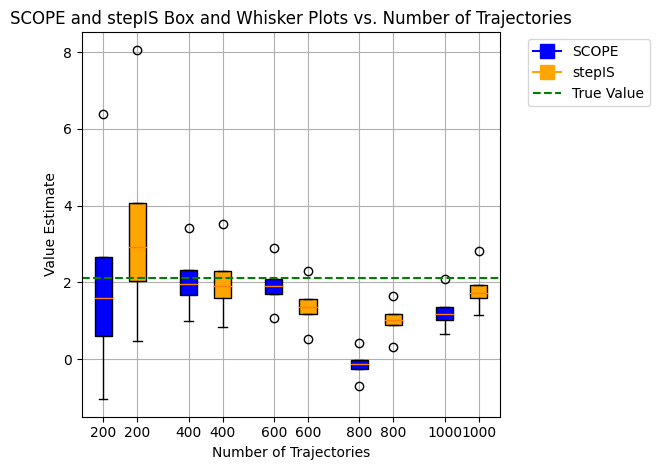

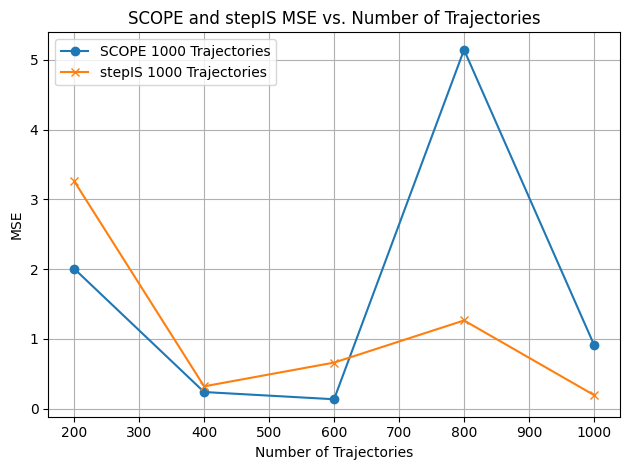

In [ ]:
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [(3,3)], 1, -2, 3, 0.9)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.9 )

## Dense Two bad regions

Number of trajectories:  200
Number of trajectories:  400
Number of trajectories:  600
Number of trajectories:  800
Number of trajectories:  1000


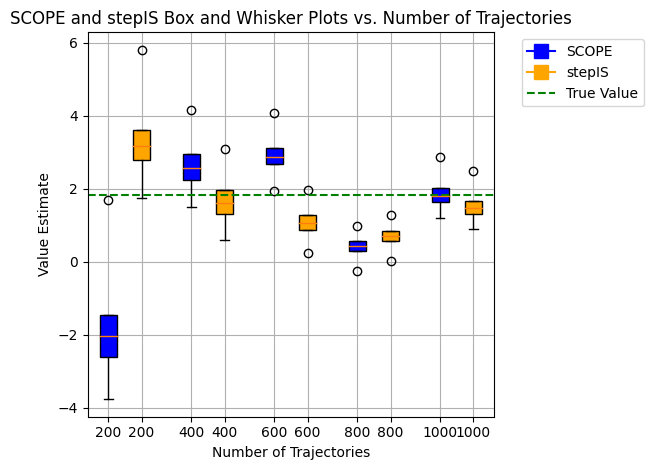

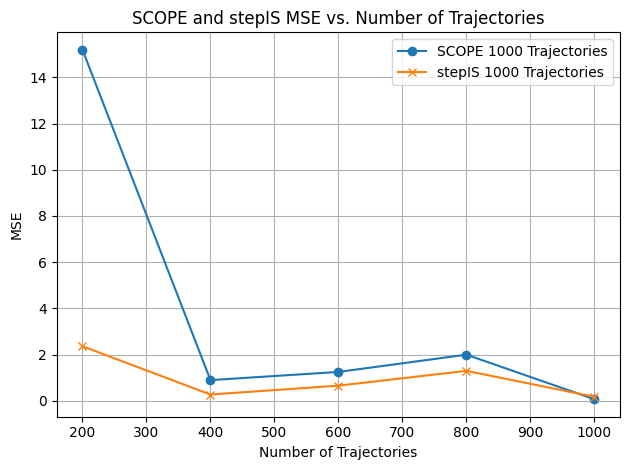

In [ ]:
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.9)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.9)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.9 )

Number of trajectories:  200
Iteration: 1
Beta: [-0.43733516  0.40609492]
Variance Scope: 0.72737648118328
----------
Iteration: 2
Beta: [-0.46901252  0.48501052]
Variance Scope: 0.7124753453769846
----------
Iteration: 3
Beta: [-0.51816447  0.60745962]
Variance Scope: 0.7037319700583222
----------
Var SCOPE_phi:  0.6831526325673333
Var IS_phi:  1.430633192936881
Percent change in variance:  -52.24823274476662
SCOPE results:  {'std_deviation': 0.4816683589949956, 'quartiles': array([1.0156228 , 1.76633774, 2.04918578, 2.38482751, 4.0000038 ]), 'max_value': 4.000003803973893, 'min_value': 1.0156228033853794, 'mean': 2.1094581092318987}
IS results:  {'std_deviation': 0.5122271231734827, 'quartiles': array([2.60200875, 3.33369389, 3.64045846, 3.97892882, 5.70308394]), 'max_value': 5.70308393644965, 'min_value': 2.6020087461701316, 'mean': 3.6883795966712807}
true eval:  1.7877866407029617
Number of trajectories:  400
Iteration: 1
Beta: [ 0.0649423  -0.31021195]
Variance Scope: 0.083205999

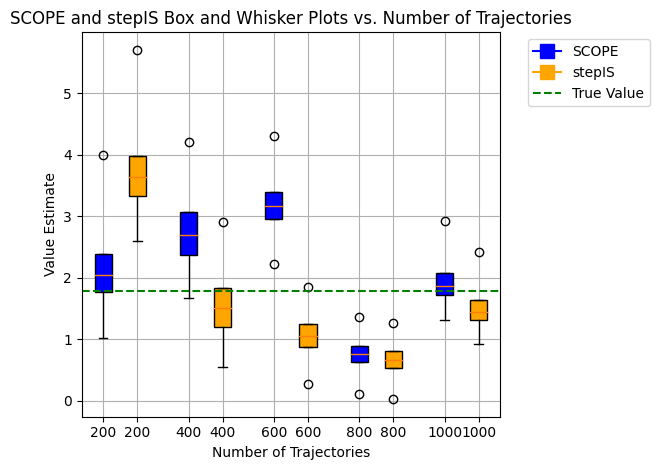

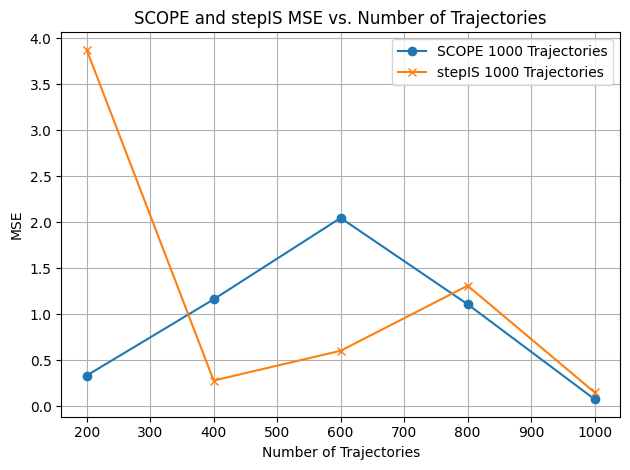

In [ ]:
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.88)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.88)

## Dense 2 bad, 0.7 for training

Number of trajectories:  200
Number of trajectories:  400
Number of trajectories:  600
Number of trajectories:  800
Number of trajectories:  1000


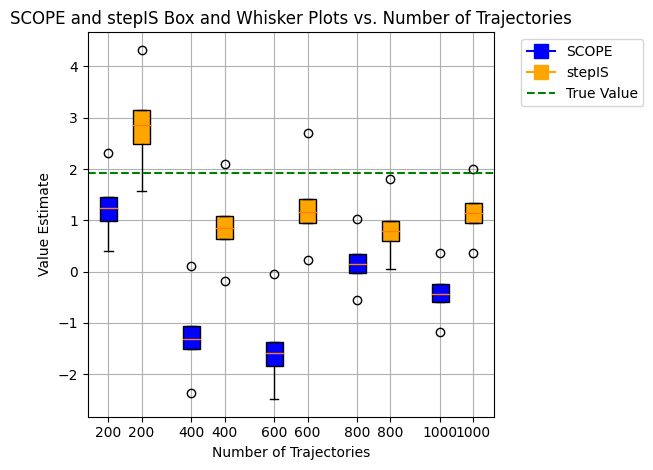

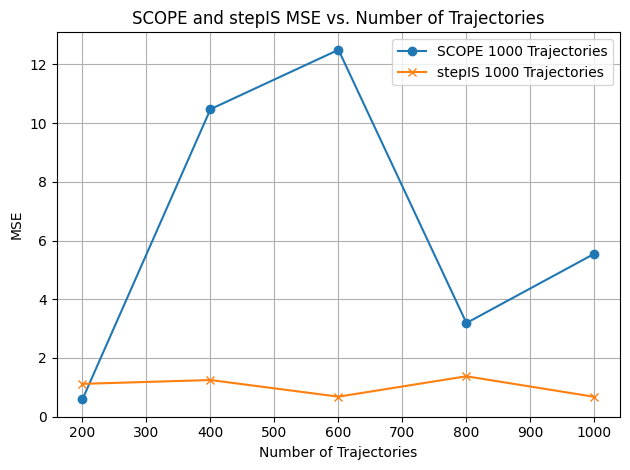

In [25]:
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.9)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.9)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.7, 0.9 )

## Sparse 2 bad regions

Number of trajectories:  200
Iteration: 1
Beta: [-0.11888223 -0.15249823]
Variance Scope: 0.019808916571213475
----------
Iteration: 2
Beta: [-0.14832728  0.07945767]
Variance Scope: 0.0029404561329163803
----------
Iteration: 3
Beta: [-0.14836491  0.07975371]
Variance Scope: 0.002940428726342731
----------
Var SCOPE_phi:  0.004096800425867617
Var IS_phi:  0.010002394679679838
Percent change in variance:  -59.04180391731204
SCOPE results:  {'std_deviation': 0.05008739856777583, 'quartiles': array([0.12149751, 0.22284163, 0.25186826, 0.29244109, 0.41353699]), 'max_value': 0.41353698883545725, 'min_value': 0.1214975124715428, 'mean': 0.2575965678270759}
IS results:  {'std_deviation': 0.0688490786493261, 'quartiles': array([0.22799388, 0.37225924, 0.41072319, 0.46432698, 0.66601988]), 'max_value': 0.6660198814156975, 'min_value': 0.22799388216940675, 'mean': 0.41925554103913865}
true eval:  -0.6899112250373142
Number of trajectories:  400
Iteration: 1
Beta: [0.05970858 0.12686291]
Varianc

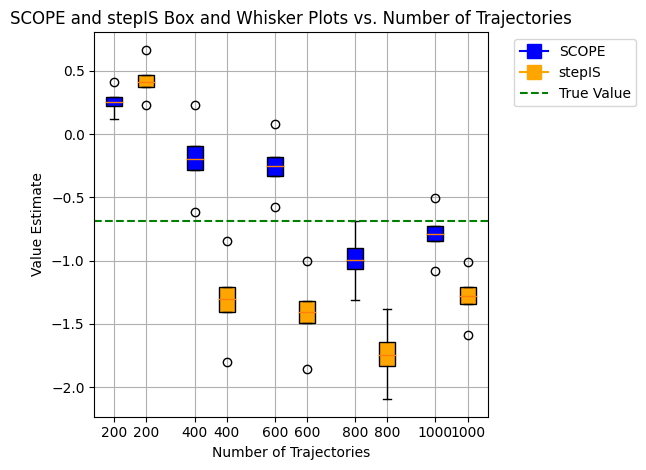

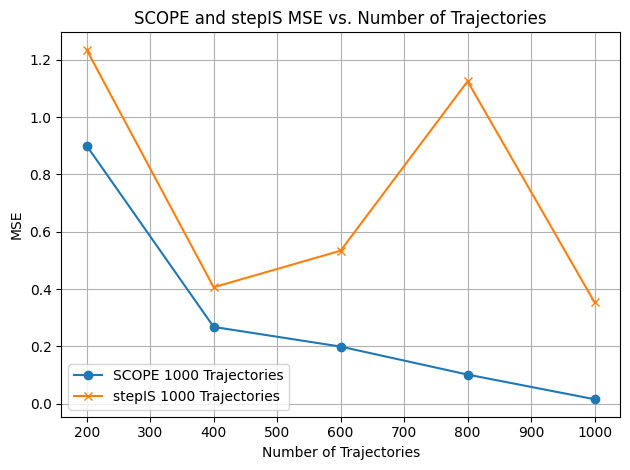

In [ ]:
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

Number of trajectories:  200
Iteration: 1
Beta: [ 0.02472101 -0.065297  ]
Variance Scope: 0.05215960690260541
----------
Iteration: 2
Beta: [ 0.01774757 -0.04557237]
Variance Scope: 0.046076234856725254
----------
Iteration: 3
Beta: [-0.00713973  0.02481437]
Variance Scope: 0.03655593170268179
----------
Var SCOPE_phi:  0.03839047028186682
Var IS_phi:  0.044707424964215814
Percent change in variance:  -14.129542659648006
SCOPE results:  {'std_deviation': 0.14187981552865908, 'quartiles': array([0.06766985, 0.22292283, 0.30845804, 0.41378531, 0.87191209]), 'max_value': 0.8719120851347623, 'min_value': 0.06766984700530358, 'mean': 0.3280657204697587}
IS results:  {'std_deviation': 0.14716714173523585, 'quartiles': array([0.15020201, 0.31546655, 0.40247404, 0.51550093, 1.0056539 ]), 'max_value': 1.0056539017256318, 'min_value': 0.15020200731493832, 'mean': 0.42459016428278606}
true eval:  -0.13537923473463173
Number of trajectories:  400
Iteration: 1
Beta: [ 0.31080249 -0.21538622]
Varian

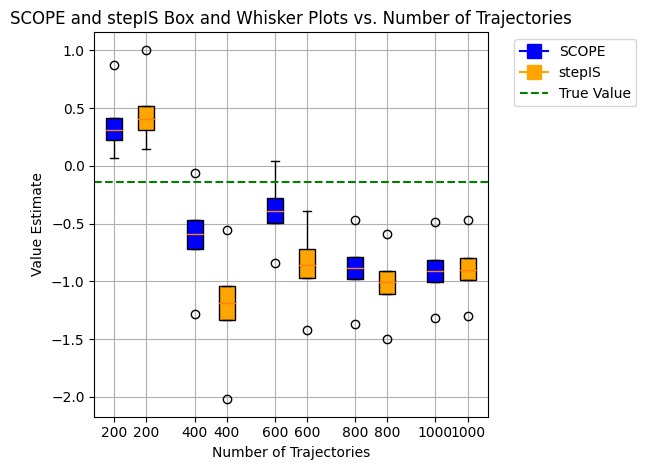

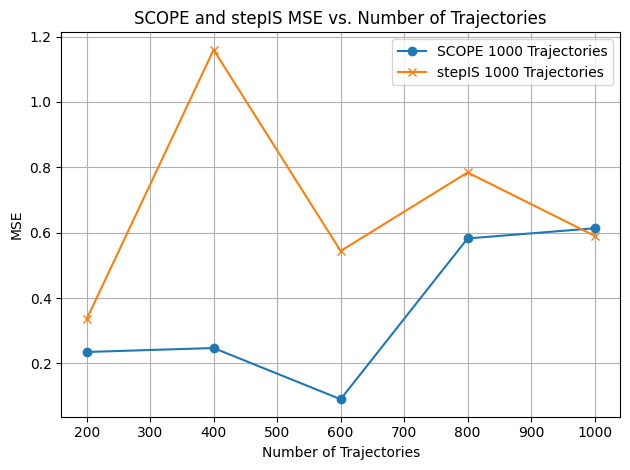

In [64]:
env = GridWorld(height, width, start, end, [(1, 2), (2, 3)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

Number of trajectories:  200
Iteration: 1
Beta: [0.12027944 0.02321779]
Variance Scope: 0.015572393763596757
----------
Iteration: 2
Beta: [0.05909455 0.03894675]
Variance Scope: 0.011004319954384688
----------
Iteration: 3
Beta: [-0.04696598  0.06621198]
Variance Scope: 0.007931424637202105
----------
Var SCOPE_phi:  0.00703802560887539
Var IS_phi:  0.010002394679679838
Percent change in variance:  -29.636593693174813
SCOPE results:  {'std_deviation': 0.054861260510516235, 'quartiles': array([0.04251605, 0.14731653, 0.1824407 , 0.21889349, 0.36957037]), 'max_value': 0.3695703681777417, 'min_value': 0.042516053302046095, 'mean': 0.18526054496956268}
IS results:  {'std_deviation': 0.0688490786493261, 'quartiles': array([0.22799388, 0.37225924, 0.41072319, 0.46432698, 0.66601988]), 'max_value': 0.6660198814156975, 'min_value': 0.22799388216940675, 'mean': 0.41925554103913865}
true eval:  -0.020747762052760577
Number of trajectories:  400
Iteration: 1
Beta: [ 0.53038027 -0.60850543]
Varia

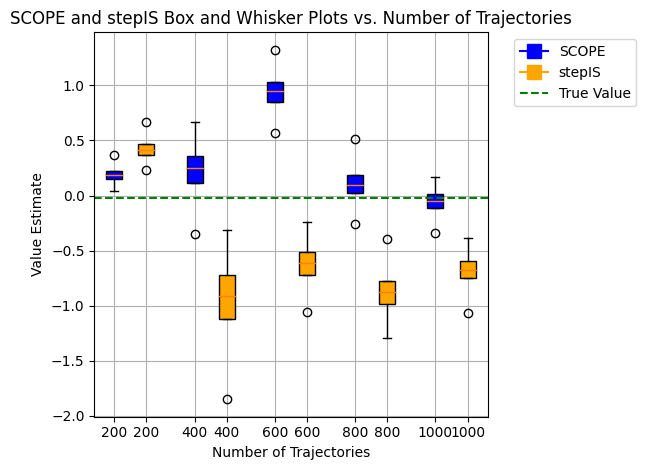

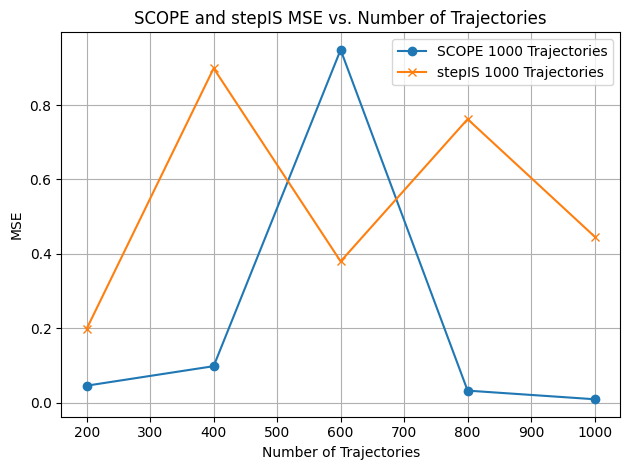

In [47]:
env = GridWorld(height, width, start, end, [(2, 2), (3, 3)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

## Sparse 3 bad regions

Number of trajectories:  200
Iteration: 1
Beta: [-0.01792763 -0.12627764  0.14496815]
Variance Scope: 0.007055171750417644
----------
Iteration: 2
Beta: [-0.00709438 -0.13342586  0.13249602]
Variance Scope: 0.004796673287030595
----------
Iteration: 3
Beta: [ 0.00676065 -0.14761943  0.12372505]
Variance Scope: 0.003714153056561899
----------
Iteration: 4
Beta: [ 0.01296849 -0.15860369  0.12636867]
Variance Scope: 0.003324366101093136
----------
Iteration: 5
Beta: [ 0.04529999 -0.22634376  0.15510714]
Variance Scope: 0.001611254270612747
----------
Iteration: 6
Beta: [ 0.06197292 -0.27097057  0.18370627]
Variance Scope: 0.0008466179179424521
----------
Iteration: 7
Beta: [ 0.06368431 -0.28032892  0.19343269]
Variance Scope: 0.0007443311645515677
----------
Iteration: 8
Beta: [ 0.06281192 -0.2790748   0.19347266]
Variance Scope: 0.0007424308096136006
----------
Iteration: 9
Beta: [ 0.06262888 -0.27870655  0.19333165]
Variance Scope: 0.0007424001934864949
----------
Var SCOPE_phi:  0.0009

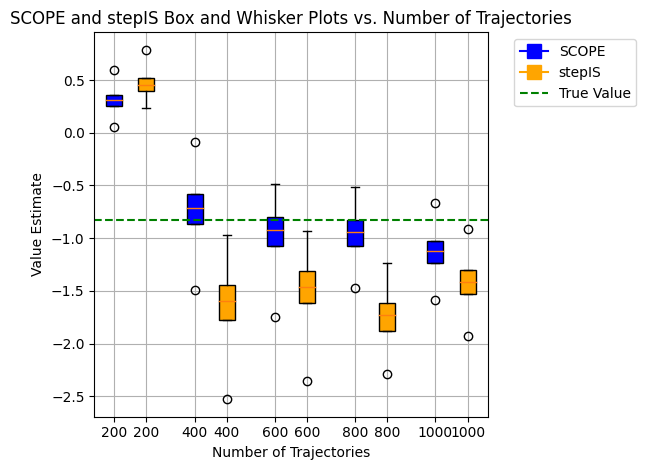

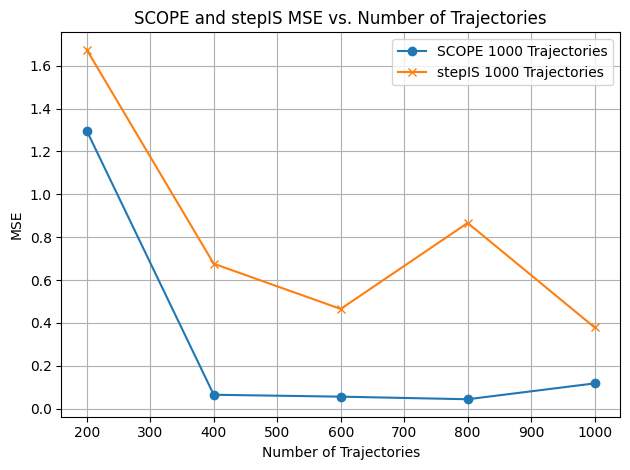

In [ ]:
env = GridWorld(height, width, start, end, [(2, 1), (2, 2), (2,3)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

Number of trajectories:  200
Iteration: 1
Beta: [-0.16418405  0.32393939  0.15439486]
Variance Scope: 0.15450367005746735
----------
Iteration: 2
Beta: [-0.14953298  0.29190318  0.08854435]
Variance Scope: 0.08195898690877264
----------
Iteration: 3
Beta: [-0.1158441   0.21490705 -0.0155358 ]
Variance Scope: 0.02994120627421509
----------
Iteration: 4
Beta: [-0.06744444  0.09202425  0.00919727]
Variance Scope: 0.015217530728394955
----------
Iteration: 5
Beta: [ 0.01792395 -0.12830617  0.10379141]
Variance Scope: -0.001219924360860658
----------
Iteration: 6
Beta: [ 0.03366046 -0.1701364   0.1384978 ]
Variance Scope: -0.0026648120483205584
----------
Iteration: 7
Beta: [ 0.03348126 -0.16972835  0.13907304]
Variance Scope: -0.002666392463028376
----------
Iteration: 8
Beta: [ 0.03342307 -0.16958084  0.13904642]
Variance Scope: -0.002666399712383853
----------
Var SCOPE_phi:  -0.0020759666122899534
Var IS_phi:  0.027022031085517317
Percent change in variance:  -107.68249657370346
SCOPE r

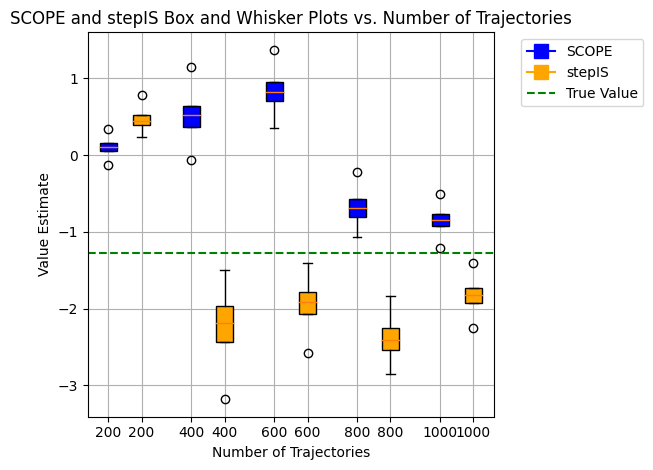

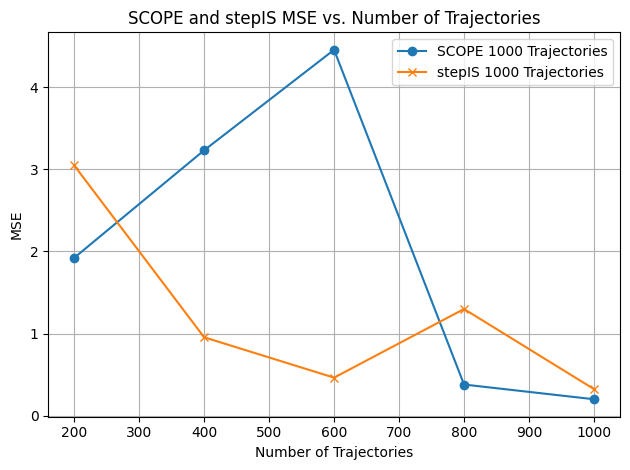

In [48]:
env = GridWorld(height, width, start, end, [(1, 1), (2, 2), (3,3)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

## Sparse 2 good regions

Number of trajectories:  200
Number of trajectories:  400
Number of trajectories:  600
Number of trajectories:  800
Number of trajectories:  1000


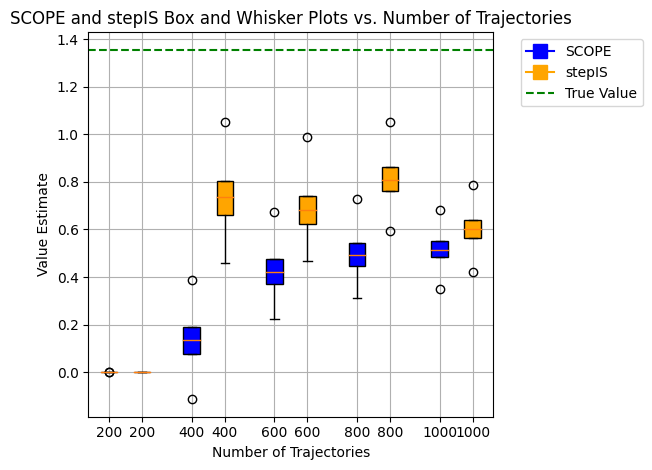

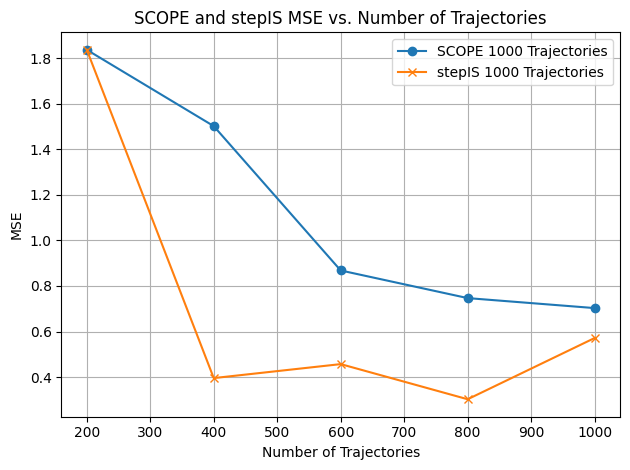

In [59]:
env = GridWorld(height, width, start, end, [], [(2, 1), (2, 2)], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.1)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

## Sparse 1 good region

Number of trajectories:  200
Number of trajectories:  400
Number of trajectories:  600
Number of trajectories:  800
Number of trajectories:  1000


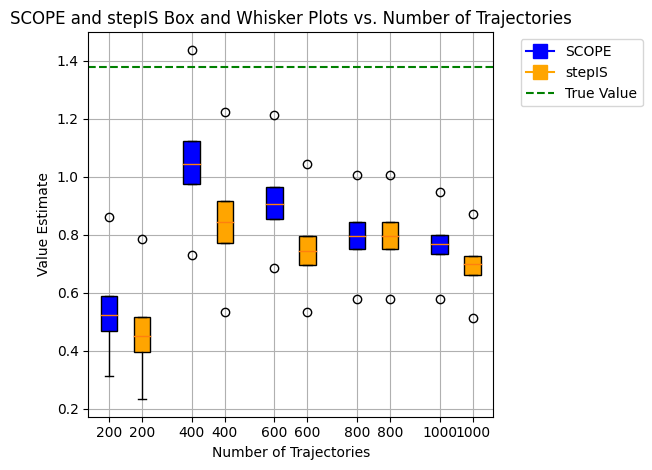

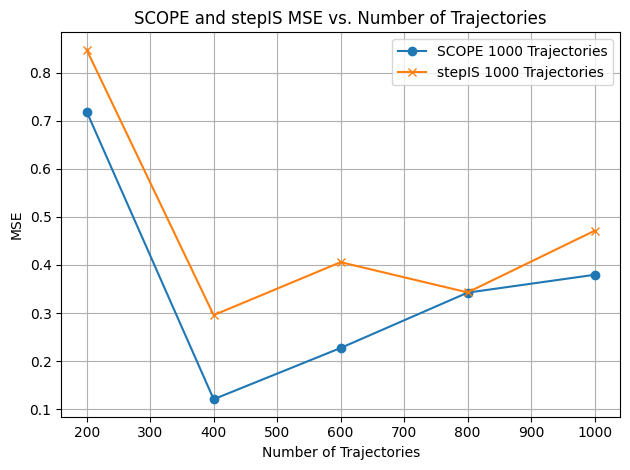

In [60]:
env = GridWorld(height, width, start, end, [], [(1, 2)], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.1)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

## Sparse, one bad region

Number of trajectories:  200
Number of trajectories:  400
Number of trajectories:  600
Number of trajectories:  800
Number of trajectories:  1000


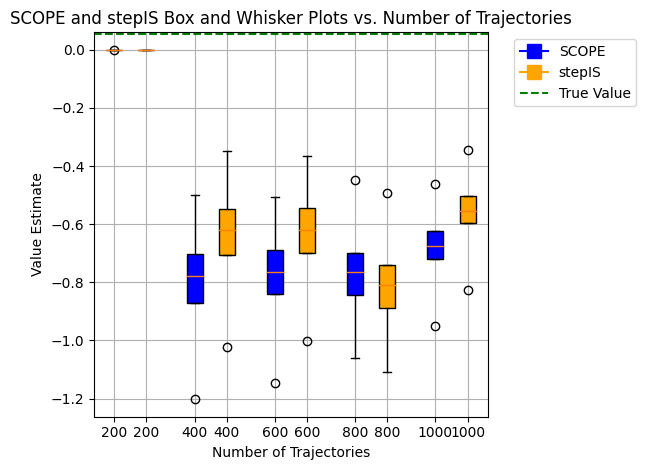

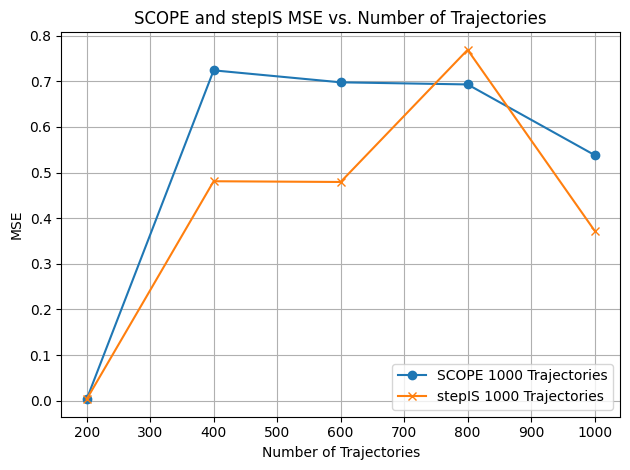

In [61]:
env = GridWorld(height, width, start, end, [(2, 2)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.0)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Dense, One bad region, similar

Number of trajectories:  200
Number of trajectories:  400
Number of trajectories:  600
Number of trajectories:  800
Number of trajectories:  1000


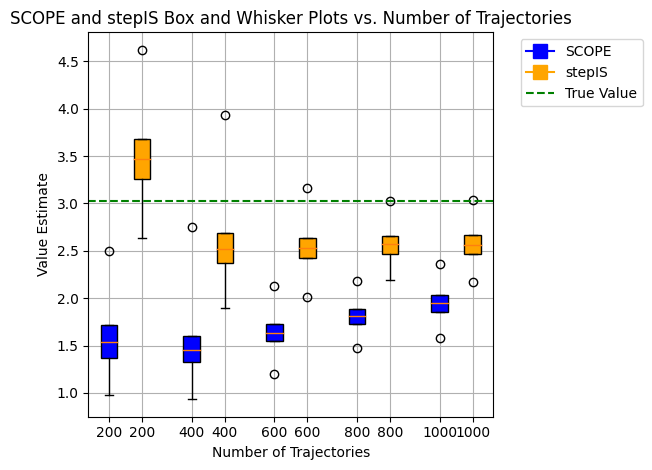

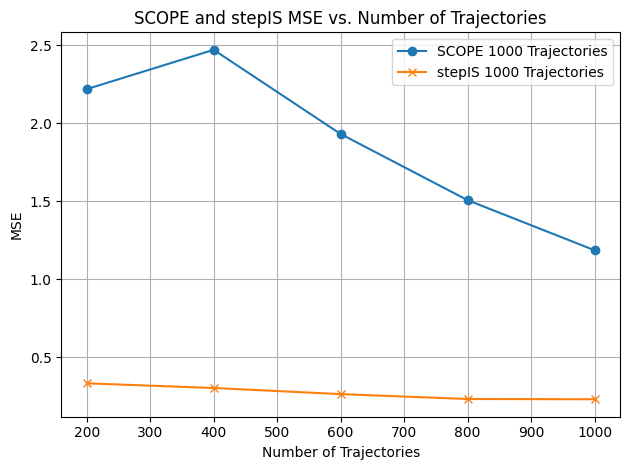

In [62]:
env = GridWorld(height, width, start, end, [(2, 3)], [], 1, -2,3, 0.8)
eval_policy = {"up": 0.36, "down": 0.14, "left": 0.14, "right": 0.36}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.8)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.8 )

## Sparse, one bad region, similar

Number of trajectories:  200
Number of trajectories:  400
Number of trajectories:  600
Number of trajectories:  800
Number of trajectories:  1000


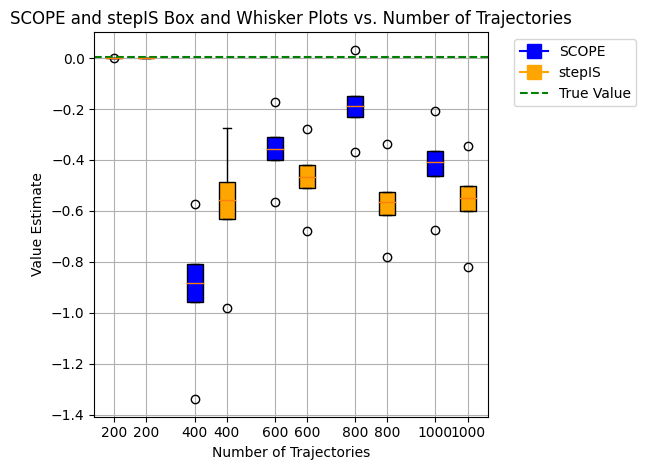

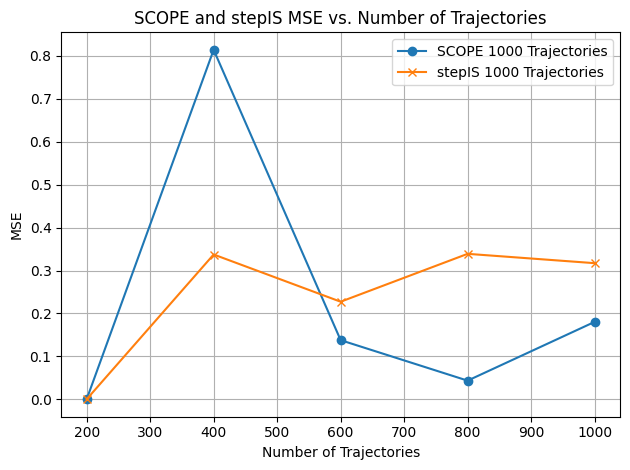

In [63]:
env = GridWorld(height, width, start, end, [(2, 3)], [], 1, -2,3, 0.01)
eval_policy = {"up": 0.36, "down": 0.14, "left": 0.14, "right": 0.36}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.01)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.01 )

# Fix

## Dense same policy

Iteration: 1
Beta: [84.85949022]
Variance Scope: 0.001736955750288871
----------
Iteration: 2
Beta: [781.51973886]
Variance Scope: -0.01589871686519473
----------
Var SCOPE_phi:  -0.11029498305288143
Var IS_phi:  0.0040720997718448615
Percent change in variance:  -2808.553061874326
SCOPE results:  {'std_deviation': 4.898643784364377, 'quartiles': array([-3876.2710367 , -3865.78412333, -3862.82905616, -3859.22679742,
       -3848.23175392]), 'max_value': -3848.231753921607, 'min_value': -3876.2710367036593, 'mean': -3862.5734105351903}
IS results:  {'std_deviation': 0.04568360351459474, 'quartiles': array([2.40985638, 2.52198738, 2.55015316, 2.57888861, 2.67431201]), 'max_value': 2.674312014037884, 'min_value': 2.409856381678845, 'mean': 2.5495888419254444}
true eval:  2.578305642637817
Var SCOPE_phi:  0.0032930280888328056
Var IS_phi:  0.0032955402301917402
Percent change in variance:  -0.07622851440015548
SCOPE results:  {'std_deviation': 0.03875198954247306, 'quartiles': array([3.168

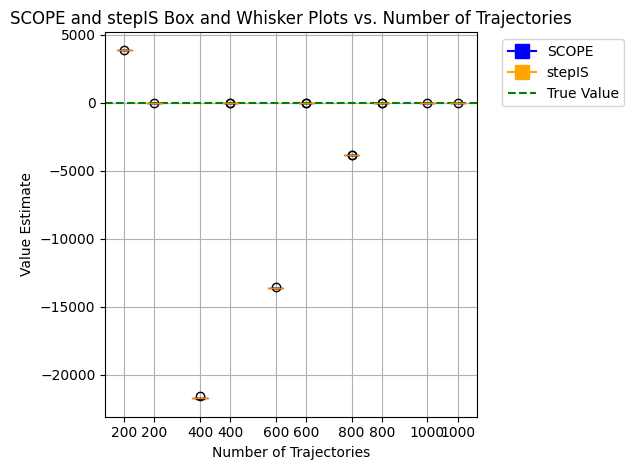

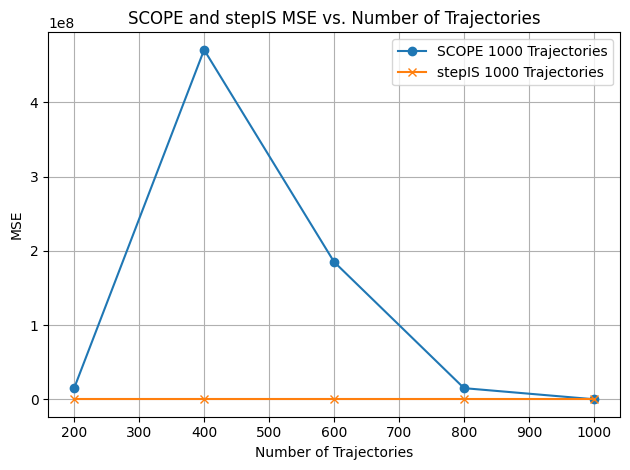

In [ ]:
env = GridWorld(height, width, start, end, [(2,3)], [], 1, -2,3, 0.8)
eval_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.8 )

## Sparse same policy

Iteration: 1
Beta: [1364.99647146]
Variance Scope: -0.08294306951449926
----------
Iteration: 2
Beta: [7929.56632766]
Variance Scope: -0.49320404945046903
----------
Var SCOPE_phi:  0.21883274287120003
Var IS_phi:  0.002079710050273173
Percent change in variance:  10422.271738911682
SCOPE results:  {'std_deviation': 71.93990927164653, 'quartiles': array([-39515.5883735 , -39341.61191795, -39294.32460419, -39239.29881666,
       -39073.42833096]), 'max_value': -39073.4283309624, 'min_value': -39515.58837350042, 'mean': -39291.67737903583}
IS results:  {'std_deviation': 0.045131215564325464, 'quartiles': array([-0.46618443, -0.32165318, -0.29252316, -0.26255155, -0.16487168]), 'max_value': -0.1648716816954902, 'min_value': -0.46618442778539393, 'mean': -0.29226941430355363}
true eval:  -0.23166339931135865
Iteration: 1
Beta: [-87381.10345007]
Variance Scope: -13.148089827300282
----------
Var SCOPE_phi:  -14.15043094761495
Var IS_phi:  0.0026770063411079292
Percent change in variance:  -

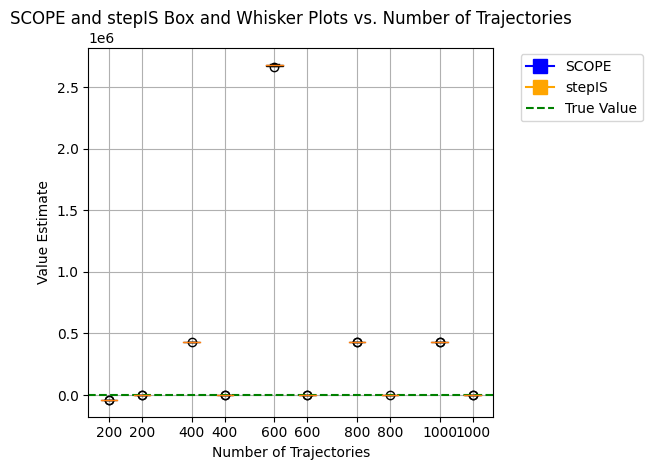

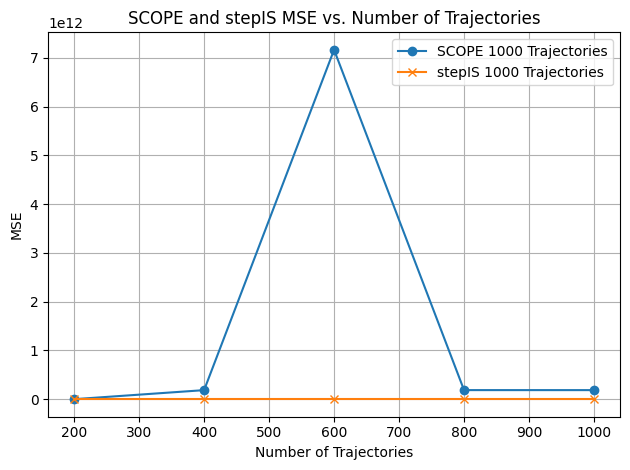

In [ ]:
env = GridWorld(height, width, start, end, [(2,3)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Sparse 2 bad regions, same policy

Iteration: 1
Beta: [-132009.73600356 1391854.55059278]
Variance Scope: -4711.163557349646
----------
Iteration: 2
Beta: [2886745.69045944 5518373.29780728]
Variance Scope: -17593.68433769513
----------
Var SCOPE_phi:  -8334.076272267383
Var IS_phi:  0.0043376660683387865
Percent change in variance:  -192132830.85032842
SCOPE results:  {'std_deviation': 64433.60494627925, 'quartiles': array([-52922307.62356604, -52805510.71870545, -52764325.2911388 ,
       -52717435.98086454, -52538058.37683399]), 'max_value': -52538058.37683399, 'min_value': -52922307.62356604, 'mean': -52760155.118833564}
IS results:  {'std_deviation': 0.04610029072420275, 'quartiles': array([-0.48861007, -0.37351477, -0.34005415, -0.30717607, -0.21516516]), 'max_value': -0.2151651620970472, 'min_value': -0.4886100714872391, 'mean': -0.34144890040061954}
true eval:  -0.33782263449598726
Iteration: 1
Beta: [-4683.02826123 87255.47148304]
Variance Scope: -135.49009751639824
----------
Iteration: 2
Beta: [ 52464.3277370

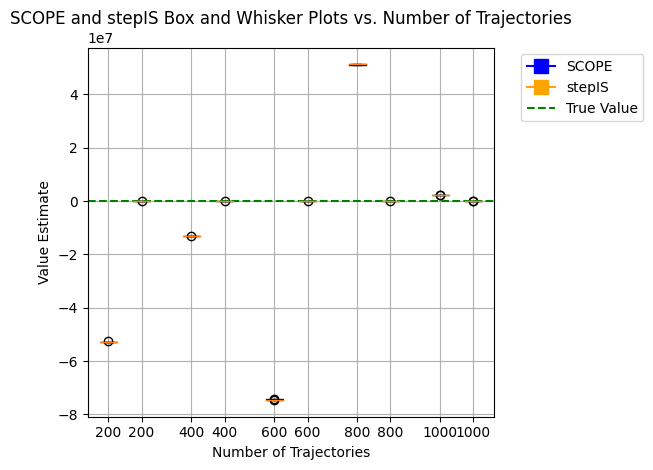

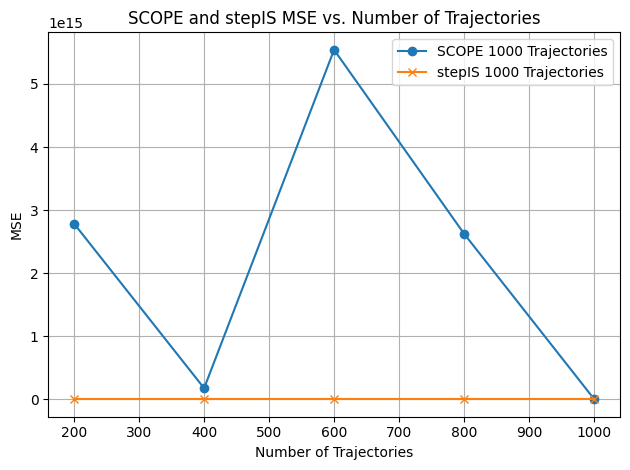

In [ ]:
env = GridWorld(height, width, start, end, [(2,3),(3,4)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

Iteration: 1
Beta: [1152786.79862728 5395387.14409886]
Variance Scope: -23639.779299305053
----------
Var SCOPE_phi:  -18848.058943022043
Var IS_phi:  0.007596704281162627
Percent change in variance:  -248108467.0685871
SCOPE results:  {'std_deviation': 67324.64478113645, 'quartiles': array([-43368107.24190983, -43281036.59783551, -43234619.75322732,
       -43186990.41798602, -42961828.42907687]), 'max_value': -42961828.42907687, 'min_value': -43368107.24190983, 'mean': -43231493.57792531}
IS results:  {'std_deviation': 0.06088802859421463, 'quartiles': array([-0.2430061 , -0.10586968, -0.06336602, -0.02366364,  0.1253893 ]), 'max_value': 0.12538929773828605, 'min_value': -0.2430061042694594, 'mean': -0.06296567270407953}
true eval:  0.04867377313050165
Iteration: 1
Beta: [-171611.3435585  5589771.10481848]
Variance Scope: -18024.369851207404
----------
Iteration: 2
Beta: [-1951116.37283829 16812460.99713976]
Variance Scope: -54354.173776410375
----------
Iteration: 3
Beta: [-6.435664

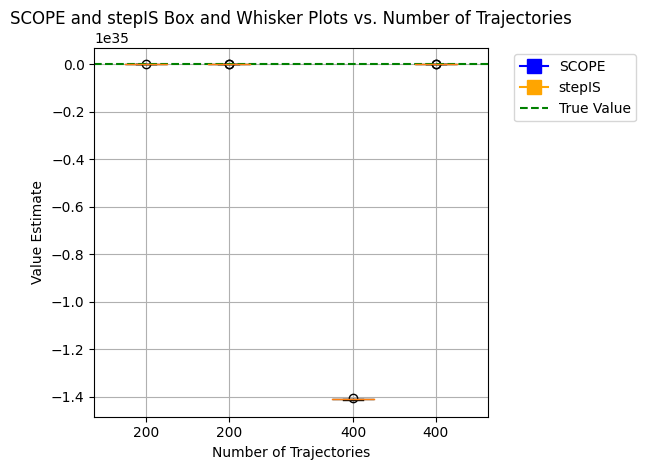

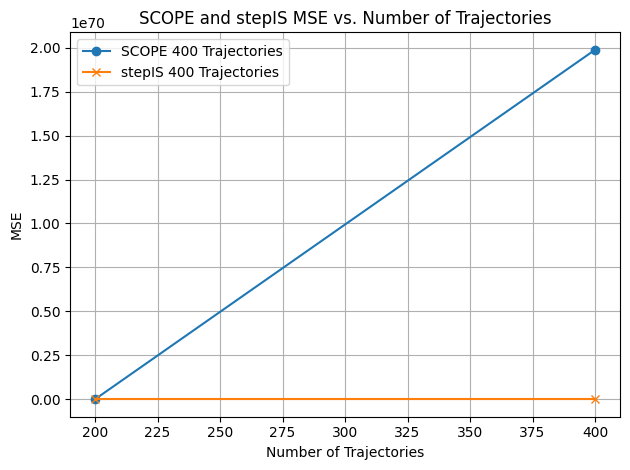

In [ ]:
env = GridWorld(height, width, start, end, [(2,3),(3,4)], [], 1, -2,3, 0.1)
eval_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
# num_trajectories = [200,400, 600, 800,1000]
num_trajectories = [200,400]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

## Sparse one bad region, very similar policies

In [ ]:
env = GridWorld(height, width, start, end, [(2, 2)], [], 1, -2,3, 0.1)
eval_policy = {"up": 0.26, "down": 0.24, "left": 0.24, "right": 0.26}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# num_trajectories = [200,400]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

NameError: ignored

## Two bad regions

In [ ]:
env_bad = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 0.5, -2, 3 )
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]

TypeError: ignored

In [ ]:
results = run_experiment(env_bad,200 ,behav_policy, eval_policy, 0.3)

Iteration: 1
Beta: [-0.23775529 -0.31538279]
Variance Scope: 0.1952989531616176
----------
Iteration: 2
Beta: [ 0.00855792 -0.08425921]
Variance Scope: 0.06434114007870334
----------
Iteration: 3
Beta: [ 0.0352773  -0.11086204]
Variance Scope: 0.06380017194509344
----------
Iteration: 4
Beta: [ 0.08619689 -0.16507904]
Variance Scope: 0.06337315182993845
----------
Var SCOPE_phi:  0.05957555228925791
Var IS_phi:  0.0683541967788337
Percent change in variance:  -12.842875643729526
SCOPE results:  {'std_deviation': 0.24342653846751341, 'quartiles': array([-1.54442223, -1.3919995 , -1.21875629]), 'max_value': -0.704109558487164, 'min_value': -2.107781336742554}
IS results:  {'std_deviation': 0.23874003778219374, 'quartiles': array([-1.9645772 , -1.82428064, -1.65781159]), 'max_value': -1.1542280596283199, 'min_value': -2.5997582966046138}
true eval:  0.404


In [ ]:
for i in num_trajectories:
  run_experiment(env_bad,i ,behav_policy, eval_policy, 0.3)
  print(i," trajectories done")

200  trajectories done
Iteration: 1
Beta: [-0.04182442  0.28337535]
Variance Scope: 0.1449970355058024
----------
Iteration: 2
Beta: [0.03501534 0.15854378]
Variance Scope: 0.12902630782358546
----------
Iteration: 3
Beta: [ 0.42167859 -0.46962023]
Variance Scope: 0.0924749963173842
----------
Var SCOPE_phi:  0.10620962200244352
Var IS_phi:  0.15946274760524215
Percent change in variance:  -33.395339289292416
SCOPE results:  {'std_deviation': 0.15043182531039923, 'quartiles': array([-0.5105846 , -0.41700359, -0.30639972]), 'max_value': 0.0391103159666555, 'min_value': -0.8527535898790396}
IS results:  {'std_deviation': 0.1866995279574805, 'quartiles': array([-1.84457456, -1.71930555, -1.60012277]), 'max_value': -1.191328549806053, 'min_value': -2.341247034329893}
true eval:  0.446
400  trajectories done
Iteration: 1
Beta: [0.01539058 0.03108489]
Variance Scope: 0.03554862988138942
----------
Iteration: 2
Beta: [ 0.06022739 -0.03786455]
Variance Scope: 0.03314401745022946
----------
Ite

200  trajectories done
400  trajectories done
600  trajectories done
800  trajectories done
1000  trajectories done


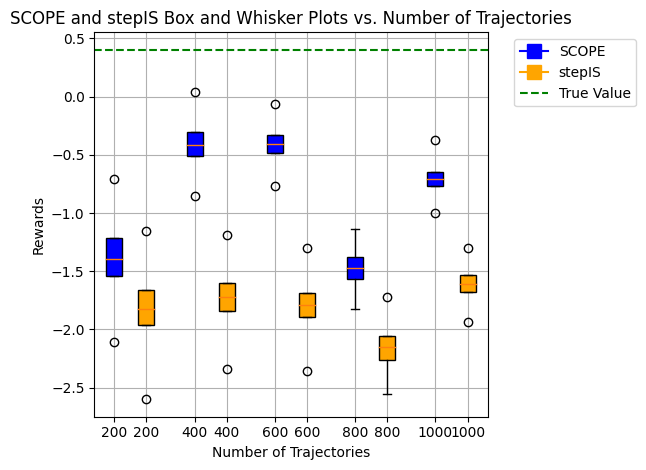

In [ ]:
plot_rewards_over_trajectories(env_bad, num_trajectories, behav_policy, eval_policy, 0.3)

## Single bad region

In [ ]:
num_trajectories = [200, 400, 600, 800, 1000]

In [ ]:
env_bad_one = GridWorld(height, width, start, end, [(2, 2)], [], 0.5, -2, 3 )
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}

In [ ]:
for i in num_trajectories:
  run_experiment(env_bad_one,i ,behav_policy, eval_policy, 0.3)
  print(i," trajectories done")

Iteration: 1
Beta: [-0.04973507]
Variance Scope: 0.018989969928276604
----------
Var SCOPE_phi:  0.020868698126695406
Var IS_phi:  0.021951280966924468
Percent change in variance:  -4.931752465199026
SCOPE results:  {'std_deviation': 0.14450085569686189, 'quartiles': array([-0.62984529, -0.52638903, -0.43341522]), 'max_value': -0.09524971245941706, 'min_value': -0.8905554592015197}
IS results:  {'std_deviation': 0.1418548069198576, 'quartiles': array([-0.77785751, -0.6810903 , -0.59055079]), 'max_value': -0.2520653864163582, 'min_value': -1.0427255213522189}
true eval:  1.862
200  trajectories done
Iteration: 1
Beta: [0.11602648]
Variance Scope: 0.06723500616069068
----------
Var SCOPE_phi:  0.08315713312155568
Var IS_phi:  0.09943635987956832
Percent change in variance:  -16.37150311790287
SCOPE results:  {'std_deviation': 0.1282095265933588, 'quartiles': array([-1.1320494 , -1.03129478, -0.95132788]), 'max_value': -0.7287495789277596, 'min_value': -1.490669289965689}
IS results:  {'s

200  trajectories done
400  trajectories done
600  trajectories done
800  trajectories done
1000  trajectories done


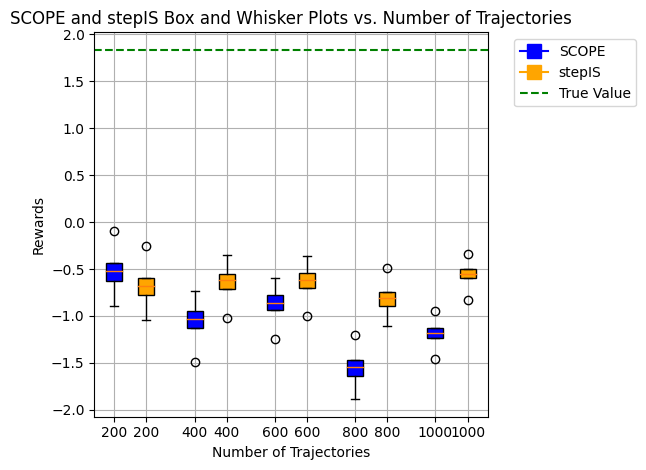

In [ ]:
plot_rewards_over_trajectories(env_bad_one, num_trajectories ,behav_policy, eval_policy, 0.3)

In [ ]:
evaluation_policies = create_policy_set(env_bad_one, run_policy,eval_policy, 1000)
true_evaluation = print("True Eval: ",calc_V_pi_e(evaluation_policies))

True Eval:  0.054029436943060644


## Two bad regions One good region

In [ ]:
env_2bad_1good = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [(3,3)], 0.5, -2, 3 )
eval_policy = {"up": 0.36, "down": 0.14, "left": 0.14, "right": 0.36}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}

In [ ]:
run_experiment(env_2bad_1good,200, behav_policy, eval_policy, 0.3)

In [ ]:
num_trajectories = [200, 400, 600, 800, 1000]

In [ ]:
for i in num_trajectories:
  run_experiment(env_2bad_1good,i ,behav_policy, eval_policy, 0.3)
  print(i," trajectories done")

Iteration: 1
Beta: [ 0.26936847  0.24418478 -0.13135848]
Variance Scope: 0.11355000414336157
----------
Iteration: 2
Beta: [ 0.17935921  0.27524364 -0.13902985]
Variance Scope: 0.09757997095395636
----------
Iteration: 3
Beta: [-0.11066584  0.37218671 -0.15931714]
Variance Scope: 0.07541270476310226
----------
Iteration: 4
Beta: [-0.11744076  0.35983304 -0.13910913]
Variance Scope: 0.07536247323110924
----------
Iteration: 5
Beta: [-0.13101001  0.33242693 -0.09488484]
Variance Scope: 0.07531777435219121
----------
Var SCOPE_phi:  0.08902138278335116
Var IS_phi:  0.14048159529280713
Percent change in variance:  -36.63128426339191
SCOPE results:  {'std_deviation': 0.16476672964322422, 'quartiles': array([-0.85525551, -0.7351853 , -0.63260107]), 'max_value': -0.28988122545184586, 'min_value': -1.200741774149905}
IS results:  {'std_deviation': 0.19171294333101496, 'quartiles': array([-1.56423915, -1.43010383, -1.31407239]), 'max_value': -0.947782831830442, 'min_value': -1.9790808157205657}

200  trajectories done
400  trajectories done
600  trajectories done
800  trajectories done
1000  trajectories done


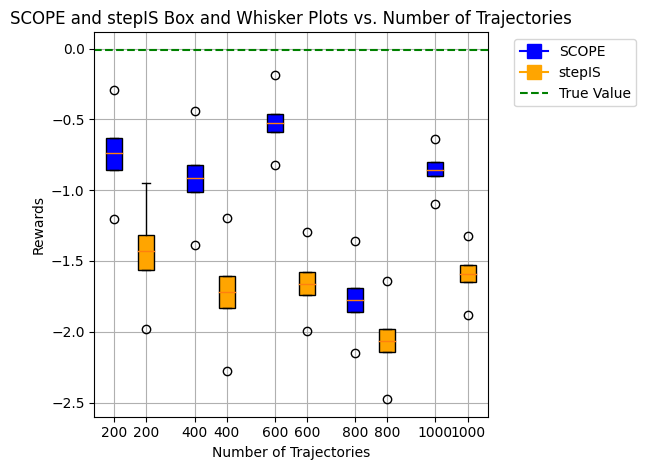

In [ ]:
plot_rewards_over_trajectories(env_2bad_1good, num_trajectories, behav_policy, eval_policy, 0.3)

In [ ]:
evaluation_policies = create_policy_set(env_2bad_1good, run_policy,eval_policy, 1000)
true_evaluation = print("True Eval: ",calc_V_pi_e(evaluation_policies))

True Eval:  -1.2020438916153051


## Two bad regions One good region similar policies

In [ ]:
env_2bad_1good_similar = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [(3,3)], 0.5, -2, 3 )
behav_policy = {"up": 0.36, "down": 0.14, "left": 0.14, "right": 0.36}
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}

In [ ]:
for i in num_trajectories:
  run_experiment(env_2bad_1good_similar,i ,behav_policy, eval_policy, 0.3)
  print(i," trajectories done")

Iteration: 1
Beta: [ 0.30143726 -0.06019801  0.05688463]
Variance Scope: 0.05336077762322047
----------
Iteration: 2
Beta: [ 0.26478906 -0.02971116  0.04379661]
Variance Scope: 0.05247084306955816
----------
Iteration: 3
Beta: [ 0.13073205  0.1236133  -0.06288369]
Variance Scope: 0.050514952849214666
----------
Iteration: 4
Beta: [ 0.14055579  0.16232143 -0.12532001]
Variance Scope: 0.050219185966840586
----------
Iteration: 5
Beta: [ 0.34975277  0.52122925 -0.80026683]
Variance Scope: 0.04819615515703848
----------
Iteration: 6
Beta: [ 0.48981108  0.62337185 -1.0578198 ]
Variance Scope: 0.04777702772954364
----------
Iteration: 7
Beta: [ 0.5169212   0.62628667 -1.08396087]
Variance Scope: 0.04775633741557941
----------
Iteration: 8
Beta: [ 0.51665659  0.62345256 -1.07975931]
Variance Scope: 0.04775618014246681
----------
Var SCOPE_phi:  0.049685243621990775
Var IS_phi:  0.055655778345727436
Percent change in variance:  -10.727609785004478
SCOPE results:  {'std_deviation': 0.1250541748

200  trajectories done
400  trajectories done
600  trajectories done
800  trajectories done
1000  trajectories done


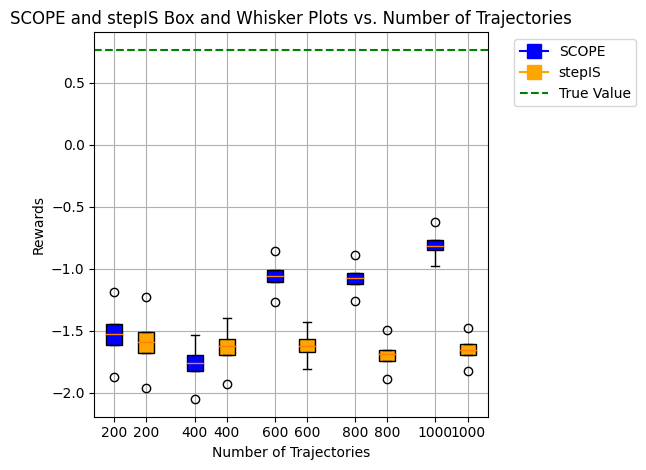

In [ ]:
plot_rewards_over_trajectories(env_2bad_1good_similar, num_trajectories, behav_policy, eval_policy, 0.3)

In [ ]:
evaluation_policies = create_policy_set(env_2bad_1good_similar, run_policy,eval_policy, 1000)
true_evaluation = print("True Eval: ",calc_V_pi_e(evaluation_policies))

True Eval:  -0.9534157241306912


In [ ]:
0.9**(1)*evaluation_policies[0][0][2]

0.0